In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
import string
from scipy import sparse
from sklearn.linear_model import Perceptron, PassiveAggressiveClassifier, SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [54]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [55]:
train_df.head()

,item_id,title,description,price,category_id
0,0,Картина,Гобелен. Размеры 139х84см.,1000.0,19
1,1,Стулья из прессованной кожи,Продам недорого 4 стула из светлой прессованно...,1250.0,22
2,2,Домашняя мини баня,"Мини баня МБ-1(мини сауна), предназначена для ...",13000.0,37
3,3,"Эксклюзивная коллекция книг ""Трансаэро"" + подарок","Продам эксклюзивную коллекцию книг, выпущенную...",4000.0,43
4,4,Ноутбук aser,Продаётся ноутбук ACER e5-511C2TA. Куплен в ко...,19000.0,1


In [56]:
train_df.shape

(489517, 5)

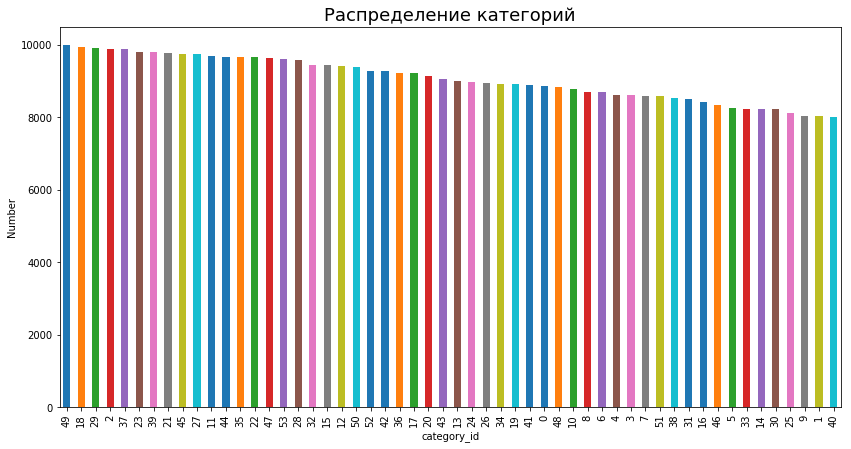

In [57]:
# Визуализируем целевую переменную
cats_sorted = train_df.groupby('category_id').size().sort_values(ascending=False)
plt.title('Распределение категорий', fontsize=18)
plt.ylabel('Number')
cats_sorted.plot.bar(figsize=(14,7));

In [59]:
# Обработка пропущенных значений
train_df.isnull().sum()

item_id        0
title          0
description    0
price          0
category_id    0
dtype: int64

In [60]:
test_df.isnull().sum()

item_id        0
title          0
description    0
price          0
dtype: int64

In [72]:
def preprocessing(df, vect_model, test=False):
    # Сливаем два текстовых признака в один
    df['text_data'] = list(df.apply(lambda x: '%s %s' %(x['title'], x['description']), axis=1))
    # Добавляем новые признаки    
    df['word_count'] = df['text_data'].apply(lambda x: len(str(x).split(" ")))
    df['char_count'] = df['text_data'].str.len()
    df['word_density'] = df['char_count'] / (df['word_count'] + 1)
    df['punctuation_count'] = df['text_data'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation)))

    def avg_word(sentence):
        words = sentence.split()
        return (sum(len(word) for word in words)/len(words))

    df['avg_word_count'] = df['text_data'].apply(lambda x: avg_word(x))
    df['numerics_count'] = df['text_data'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isdigit()]))
    df['upper_count'] = df['text_data'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
    # Приводим весь текст к нижнему регистру
    df['text_data'] = df['text_data'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    # Удаляем знаки препинания
    df['text_data'] = df['text_data'].str.replace('[^\w\s]','')
    # Применяем "операцию стемминга"
    stemmer = SnowballStemmer("russian") 
    df['text_data'] = df['text_data'].apply(lambda x: stemmer.stem(x))
    # Задействуем IF-IDF модель
    if test == False:
        vect_model = df['text_data']
    vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=None)
    fitted_vectorizer = vectorizer.fit(vect_model)
    transformed_text_data = fitted_vectorizer.transform(df['text_data'])
    # Делаем выборку числовых признаков
    cols_to_drop = ['text_data', 'title', 'description', 'category_id']
    
    if test == True:
        cols_to_drop = ['text_data', 'title', 'description']
        
    num_data = df[list(set(df.columns.tolist())-set(cols_to_drop))]
    # Масштабируем их и затем сливаем с текстовой моделью
    for i in num_data.columns:
        num_data[i] = MinMaxScaler().fit_transform(num_data[i][:, None])
        transformed_text_data = sparse.hstack((transformed_text_data, np.array(num_data[i])[:, None]))
        
    return transformed_text_data, vect_model

In [74]:
train_data, vect_model = preprocessing(df=train_df, vect_model=train_df)
test_data = preprocessing(df=test_df, vect_model=vect_model, test=True)[0]

In [75]:
train_data.shape, test_data.shape

((489517, 801311), (243166, 801311))

In [76]:
# Выделяем целевую переменную
y = train_df['category_id']

In [77]:
# Выделяем валидационный сет в обучающей выборке, чтобы избежать переобучения
X_train, X_valid, y_train, y_valid = train_test_split(train_data, y, test_size=0.2, random_state=23)

### Naive Bayes Classifier

In [36]:
%%time
mnb_clf = MultinomialNB()
mnb_clf.fit(X_train, y_train)

Wall time: 2.73 s


In [37]:
y_pred = mnb_clf.predict(X_valid)
accuracy_score(y_pred, y_valid)

0.856543144304625

### Gradient Decent

In [38]:
%%time
sgd_clf = SGDClassifier(max_iter=10)
sgd_clf.fit(X_train, y_train)

Wall time: 1min 30s


In [39]:
y_pred = sgd_clf.predict(X_valid)
accuracy_score(y_pred, y_valid)

0.8455017159666612

### Perceptron

In [40]:
%%time
perc_clf = Perceptron(tol=1e-3)
perc_clf.fit(X_train, y_train)

Wall time: 58.8 s


In [41]:
y_pred = perc_clf.predict(X_valid)
accuracy_score(y_pred, y_valid)

0.8480552377839516

### PassiveAggressiveClassifier

In [42]:
%%time
pac_clf = PassiveAggressiveClassifier(tol=1e-3)
pac_clf.fit(X_train, y_train)

Wall time: 1min 28s


In [43]:
y_pred = pac_clf.predict(X_valid)
accuracy_score(y_pred, y_valid)

0.8695763196600752

### Voting Classifier

In [47]:
%%time
voting_clf = VotingClassifier(
    estimators=[('mnb_clf', mnb_clf), ('sgd_clf', sgd_clf), ('perc_clf', perc_clf), ('pac_clf', pac_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

Wall time: 4min


In [48]:
y_pred = voting_clf.predict(X_valid)
accuracy_score(y_pred, y_valid)

0.8750817126981533

### Финальная модель и ее предсказания на тестовой выборке

In [78]:
%%time
final_clf = VotingClassifier(
    estimators=[('mnb_clf', mnb_clf), ('sgd_clf', sgd_clf), ('perc_clf', perc_clf), ('pac_clf', pac_clf)],
    voting='hard')
final_clf.fit(train_data, y)

Wall time: 5min 14s


In [81]:
y_pred_test = final_clf.predict(test_data)

In [84]:
d = {'item_id': test_df['item_id'], 'category_id': y_pred_test}
res = pd.DataFrame(data=d)

In [106]:
export_csv = res.to_csv (r'C:\Users\Admin\Anaconda3\Scripts\Learning\avito\export_dataframe.csv', index = None, header=True)